In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, multivariate_t, chi2
import DyGraph as dg
from sklearn.preprocessing import StandardScaler
import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd
import requests
import geopandas as gpd

Functions

In [2]:
def log_lik(mean,cov, X, liktype, nu = None, prec = None, gamma = None, n = 10):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    elif np.isin(liktype, ("skew-group-t", "group-t")):
        lik  = 0.0
        #print(X)
        for i in range(X.shape[0]):
            lik += np.log(dg.generalized_skew_t( X[i], prec, nu = nu, gamma = gamma, n = n))
    else:
        assert False, "likelihood not correct"

    return lik

def log_lik_all(w, thetas, X, lik_type, nus, gammas = None):

    if gammas is None:
        gammas = [None] * len(thetas)

    lik_tmp = []
    for j in range(len(thetas)):
        lik_tmp.append(log_lik(np.zeros(thetas[j].shape[1]) ,np.linalg.inv(thetas[j]), X[j*w:(j+1)*w], liktype = lik_type, prec =thetas[j],  nu = nus[j], gamma = gammas[j]))

    return np.array(lik_tmp)
            
def nr_params(thetas, lik_type):
    
    nr_params_tmp = []
    for iii in range(len(thetas)):
        theta_t = thetas[iii].copy()
        theta_t[np.abs(theta_t)<1e-3] = 0
        if lik_type == 't':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],0)] != 0) + 1.0)
        elif lik_type == 'group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],0)] != 0) + float(theta_t.shape[0]))
        elif lik_type == 'skew-group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],0)] != 0) + float(theta_t.shape[0]) + float(theta_t.shape[0]))
        else:
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],0)] != 0))

    return np.array(nr_params_tmp)


def get_active_num_param(thetas):
    tmp = []
    d = thetas.shape[1]
    thetas[np.abs(thetas)<1e-3] = 0
    for t in range(thetas.shape[0]):
        if t == 0:
            nr_pr_tmp = np.sum(np.abs(thetas[0][np.triu_indices(d, 0)]) >1e-5 )
            tmp.append(nr_pr_tmp)
        else:
            mask = np.abs(thetas[t][np.triu_indices(d, 0)]) >1e-5  
            nr_pr_tmp =np.sum( np.abs(thetas[t][np.triu_indices(d, 0)][mask] - thetas[t-1][np.triu_indices(d, 0)][mask])> 1e-5)
            tmp.append(nr_pr_tmp)

    return np.sum(tmp)




Load data

In [3]:
with open(f'../data/AQI/cleaned_aqi.pkl', 'rb') as handle:
    ts_df = pickle.load(handle)
scaler = StandardScaler()
ts_df = ts_df.iloc[10:3160]
ts_df_scaled = scaler.fit_transform(ts_df)

df  = []

for y in range(2014,2023):
    d_tmp = pd.read_csv(f"../data/AQI/daily_aqi_by_county_{y}.csv")
    d_tmp = d_tmp.loc[d_tmp['State Name'] == 'California']
    d_tmp = d_tmp[['county Name', 'Date', 'AQI']].pivot(index = 'Date', columns='county Name', values='AQI')
    df.append(d_tmp)

df = pd.concat(df)


df_t = df.ffill().copy()
df_t = df_t.dropna(axis=1)
#df_t = df_t.iloc[200:3000]
print(df_t.index[0])
print(df_t.index[-1])


2014-01-01
2022-10-31


Load spatial

In [3]:
wikiurl="https://en.wikipedia.org/wiki/User:Michael_J/County_table"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
sites = pd.read_html(response.content)[-1]
sites = sites.loc[(sites['State'] == 'CA') & np.isin(sites['County [2]'], ts_df.columns)]
sites['Latitude'] = sites['Latitude'].str.replace('°','')
sites['Latitude'] = sites['Latitude'].str.replace('+','')
sites['Latitude'] = sites['Latitude'].str.replace('–','')
sites['Latitude'] = sites['Latitude'].astype(float)
sites['Longitude'] = sites['Longitude'].str.replace('°','')
sites['Longitude'] = sites['Longitude'].str.replace('+','')
sites['Longitude'] = sites['Longitude'].str.replace('–','')
sites['Longitude'] = sites['Longitude'].astype(float)

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371.0 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

   
locs = np.array(sites[['Latitude', 'Longitude']])
d = locs.shape[0]
R = np.zeros((d, d))

for i in range(d):
   for j in range(d):
      R[i,j] = distance(locs[i], locs[j])



G_geo = nx.from_numpy_array(R)
pos_spatial = {i:locs[i] for i in range(len(locs))}

C:\Users\ragna\AppData\Local\Temp\ipykernel_13188\3061409443.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Latitude'] = sites['Latitude'].str.replace('+','')
C:\Users\ragna\AppData\Local\Temp\ipykernel_13188\3061409443.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Longitude'] = sites['Longitude'].str.replace('+','')


In [8]:
dygl_aqi = dg.dygl_inner_em(X = ts_df_scaled[:2700], obs_per_graph=30, max_iter=10000, lamda= 7.0*R/np.max(R), kappa=0.05, lik_type='gaussian', tol = 1e-2)
dygl_aqi.fit(temporal_penalty='element-wise', nr_workers=1, verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

Error 6.21E-2:   1%|          | 99/10000 [00:10<18:24,  8.97it/s]

KeyboardInterrupt: 

In [4]:
with open(f'AQI_t_False_model_ew.pkl', 'rb') as handle:
    AQI_dict_t = pickle.load(handle)

with open(f'AQI_t_True_model_ew.pkl', 'rb') as handle:
    AQI_dict_t_spatial = pickle.load(handle)

with open(f'AQI_gaussian_False_model_ew.pkl', 'rb') as handle:
    AQI_dict_g = pickle.load(handle)

with open(f'AQI_gaussian_True_model_ew.pkl', 'rb') as handle:
    AQI_dict_g_spatial = pickle.load(handle)


Plot some edges

1958


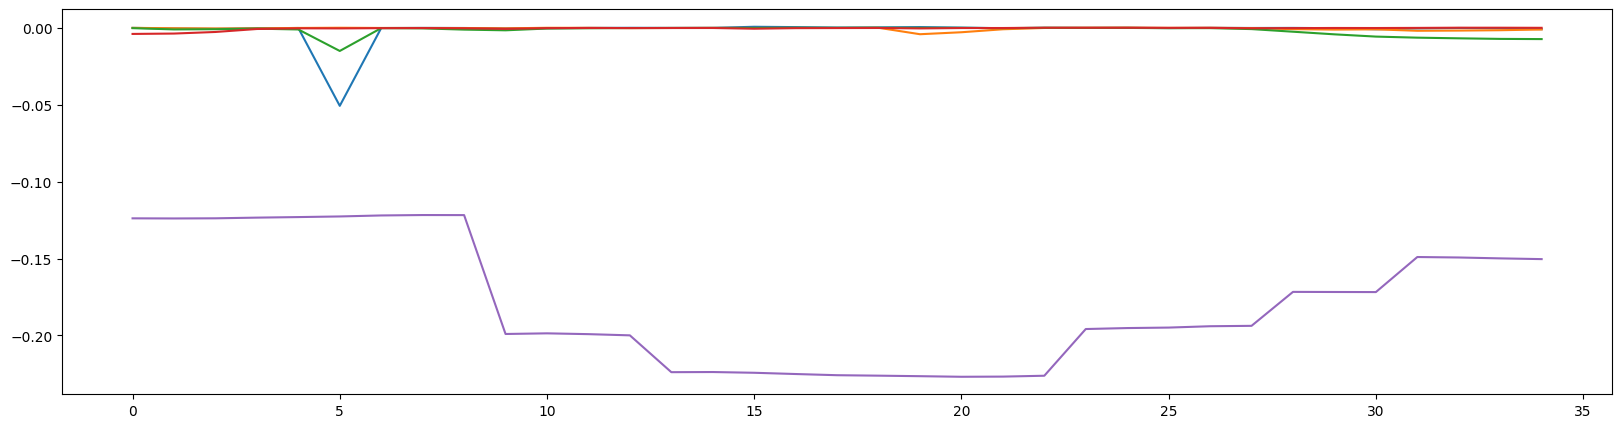

In [5]:
k_index = 5
a_index = 14

print(np.sum(np.abs(AQI_dict_t['thetas'][k_index][a_index][0] )< 1e-2))

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,1])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,2])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,3])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,4])
ax.plot(AQI_dict_t['thetas'][k_index][a_index][:,0,5])

# Find optimal using AIC

In [6]:
def find_aic(AQI_dict, ts_df_scaled, model):

    AICs = np.zeros((len(AQI_dict['kappas']), len(AQI_dict['alphas'])))
    BICs = np.zeros((len(AQI_dict['kappas']), len(AQI_dict['alphas'])))
    EBICs = np.zeros((len(AQI_dict['kappas']), len(AQI_dict['alphas'])))

    pbar = tqdm.tqdm(total = np.prod(AICs.shape))

    for k_cnt, kappa in enumerate(AQI_dict['kappas']):
        for a_cnt, alpha in enumerate(AQI_dict['alphas']):
            pbar.update()
            try:
                thetas = AQI_dict['thetas'][k_cnt][a_cnt].copy()
                d = thetas.shape[1]
                nus =  AQI_dict['nus'][k_cnt][a_cnt]
                liks = log_lik_all(AQI_dict['obs_per_graph'], thetas, ts_df_scaled, AQI_dict['lik_type'], nus, gammas = None)
                #nr_params_val = nr_params(thetas, model)
                nr_params_val = get_active_num_param(thetas)
                AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))
                BICs[k_cnt, a_cnt] = np.sum(nr_params_val)*np.log(90) - 2*np.sum(liks)
                EBICs[k_cnt, a_cnt] = np.sum(nr_params_val)*np.log(90) - 2*np.sum(liks) + np.log(d)*np.sum(nr_params_val)*4*0.5
            except:
                AICs[k_cnt, a_cnt] = np.nan
                continue

    pbar.close()

    return AICs, BICs, EBICs


      

In [7]:
AQI_dict_t.keys()

dict_keys(['thetas', 'nus', 'F_errors', 'alphas', 'kappas', 'obs_per_graph', 'lik_type', 'tol', 'index', 'R', 'X'])

In [8]:
nr_params_val = nr_params(AQI_dict_g['thetas'][3][1].copy(), 'gaussian')
print(np.sum(nr_params_val))

nr_actparams_val = get_active_num_param(AQI_dict_g['thetas'][3][1].copy())
nr_actparams_val

34301


27363

In [11]:
AIC_t, BIC_t, EBIC_t = find_aic(AQI_dict_t, ts_df_scaled, 't')
AIC_g, BIC_g, EBIC_g  = find_aic(AQI_dict_g, ts_df_scaled, 'gaussian')
AIC_t_spat, BIC_t_spat, EBIC_t_spat  = find_aic(AQI_dict_t_spatial, ts_df_scaled, 't')
AIC_g_spat, BIC_g_spat, EBIC_g_spat = find_aic(AQI_dict_g_spatial, ts_df_scaled, 'gaussian')

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:07<00:00,  5.96it/s]


In [14]:
AIC_t[0]

array([368967.29230695, 369223.86786054, 369528.86513876, 369775.7860136 ,
       370021.94617009, 370498.98137374, 371061.46494635, 371751.97605756,
       372491.98992998, 373382.98870499, 374433.67620585, 375858.20854276,
       377880.79196509, 380815.2633066 , 384691.95930026, 389350.82935501,
       395322.96298926, 402932.28302317, 411657.53769193, 417751.86989452])

(0.0, 3.7)

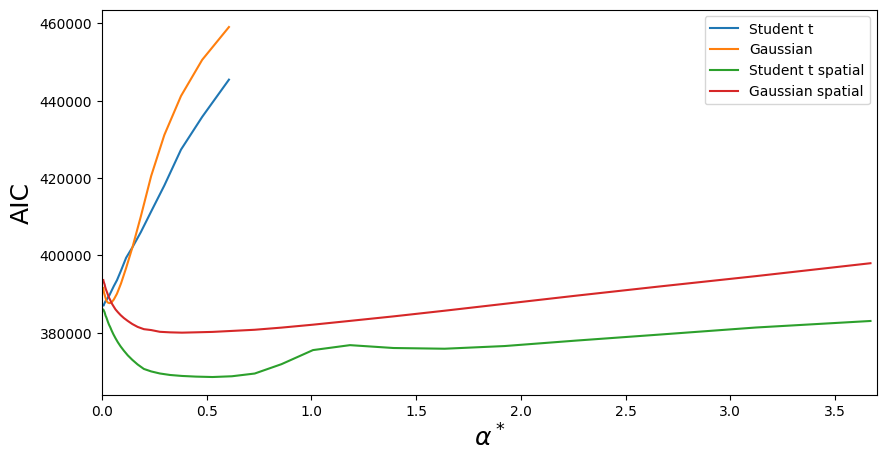

In [21]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(AQI_dict_t['alphas'], BIC_t[2], label = 'Student t')
ax.plot(AQI_dict_g['alphas'], BIC_g[2], label = 'Gaussian')
ax.plot(AQI_dict_t_spatial['alphas'], BIC_t_spat[2], label = 'Student t spatial')
ax.plot(AQI_dict_g_spatial['alphas'], BIC_g_spat[2], label = 'Gaussian spatial')
ax.legend()
ax.set_xlabel(r'$\alpha^*$', fontdict={'fontsize':18})
ax.set_ylabel(r'AIC', fontdict={'fontsize':18})
ax.set_xlim((0,3.7))

In [70]:

AQI_dict_g_spatial['alphas'][np.argmin(BIC_g_spat[3])]
print(np.argmin(BIC_g_spat[3]))

24


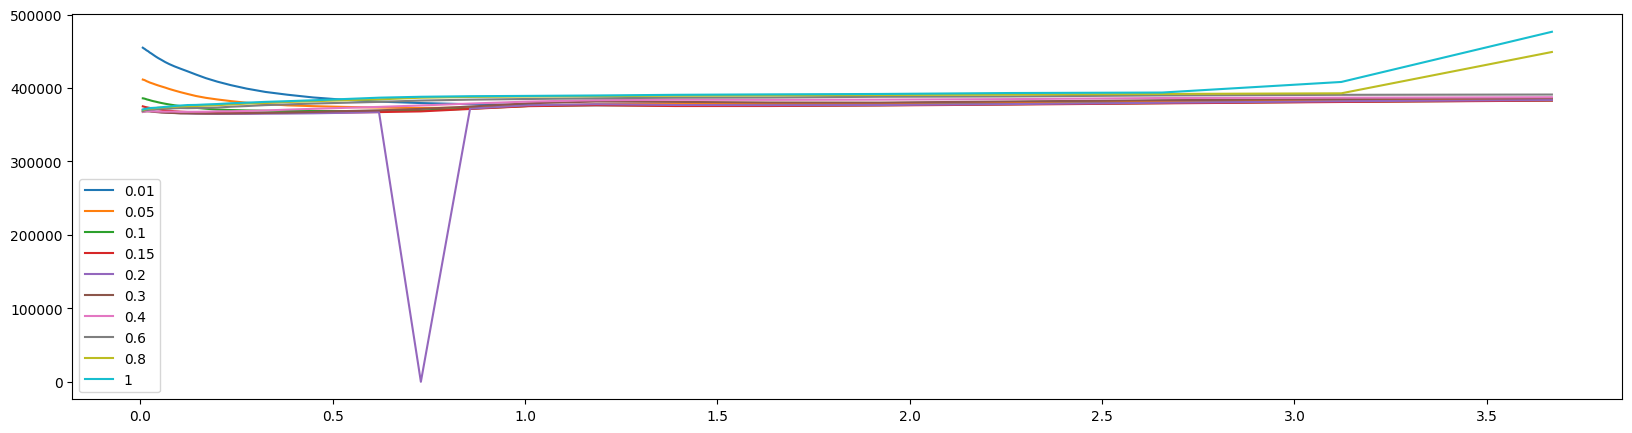

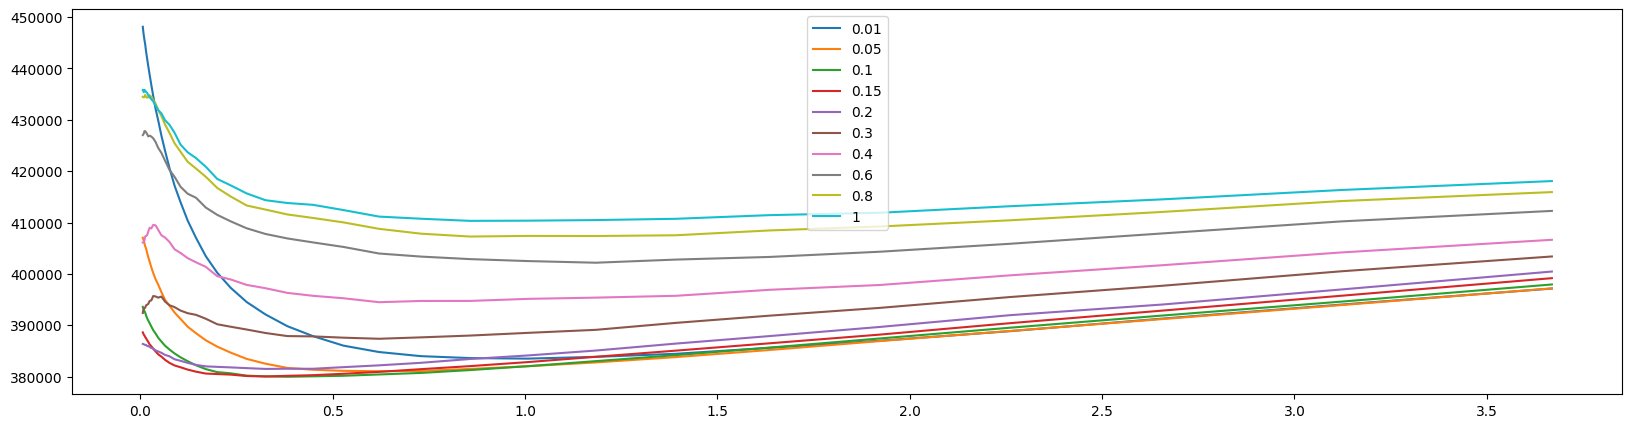

In [23]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
for i in range(10):
    ax.plot(AQI_dict_t_spatial['alphas'], BIC_t_spat[i], label = np.round(AQI_dict_t_spatial['kappas'][i],2))
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (20,5))
for i in range(10):
    ax.plot(AQI_dict_g_spatial['alphas'], BIC_g_spat[i], label = np.round(AQI_dict_g_spatial['kappas'][i],2))
ax.legend()

# Plot On California

Plot example graphs

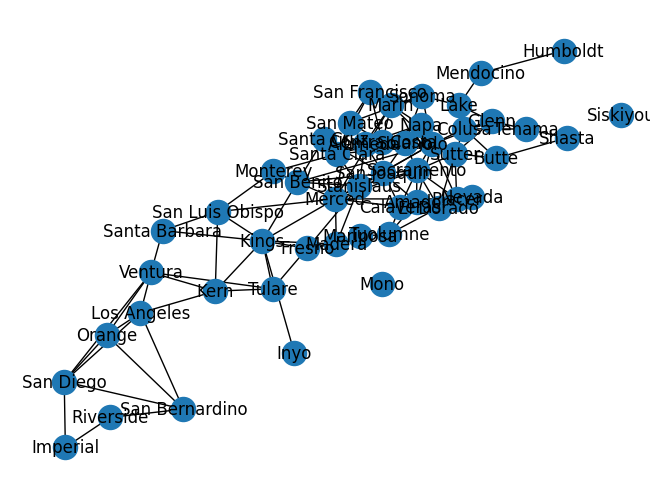

In [24]:
G1 = AQI_dict_t_spatial['thetas'][0][31][0].copy()
G1[np.abs(G1)<1e-2] = 0
np.fill_diagonal(G1,0)
G1  = nx.from_numpy_array(G1)
nx.draw(G1, labels={i:n for i,n in enumerate(ts_df.columns)}, with_labels = True, pos = pos_spatial)

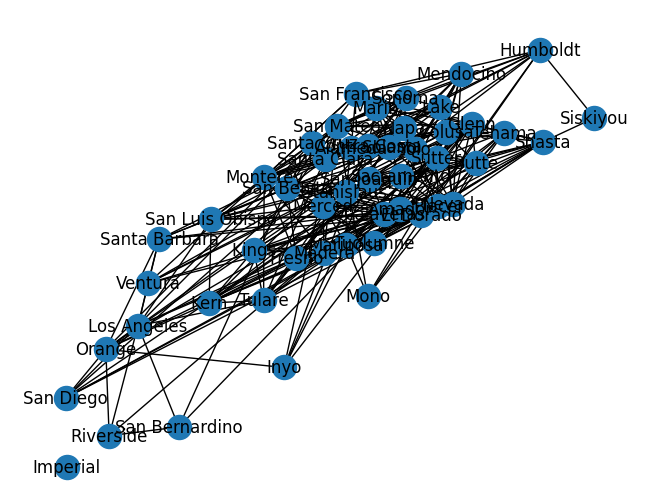

In [12]:
G2 = AQI_dict_t['thetas'][3][19][50].copy()
G2[np.abs(G2)<1e-3] = 0
np.fill_diagonal(G2,0)
G2  = nx.from_numpy_array(G2)
nx.draw(G2, labels={i:n for i,n in enumerate(ts_df.columns)}, with_labels = True, pos = pos_spatial)

Plot on California

In [25]:
dict_used = AQI_dict_g_spatial

In [28]:
AQI_dict_g_spatial['alphas'][24]

0.32527739973026315

In [29]:
import geopandas as gpd
shape_in = gpd.read_file('../../ca-county-boundaries/CA_Counties/CA_COUNTIES_TIGER2016.shp')
shape_in.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,NaN,NaN,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,NaN,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,NaN,42200,NaN,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,NaN,NaN,NaN,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,NaN,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [33]:
df_t.index

Index(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
       '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
       ...
       '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25', '2022-10-26',
       '2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31'],
      dtype='object', name='Date', length=3226)

In [61]:
df_t.index = pd.to_datetime(df_t.index)

In [41]:
df_t.loc[(df_t.index <= datetime(2019,12,31)) & (df_t.index >= datetime(2019,8,1)) ]

county Name,Alameda,Amador,Butte,Calaveras,Colusa,Contra Costa,El Dorado,Fresno,Glenn,Humboldt,...,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Tulare,Tuolumne,Ventura,Yolo
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-01,23.0,51.0,58.0,51.0,52.0,27.0,71.0,101.0,44.0,17.0,...,36.0,29.0,15.0,49.0,50.0,87.0,126.0,80.0,67.0,43.0
2019-08-02,28.0,80.0,50.0,64.0,42.0,33.0,87.0,77.0,43.0,2.0,...,32.0,46.0,14.0,49.0,58.0,61.0,126.0,74.0,71.0,54.0
2019-08-03,39.0,67.0,46.0,71.0,43.0,41.0,90.0,119.0,41.0,26.0,...,31.0,44.0,13.0,112.0,50.0,54.0,126.0,87.0,90.0,48.0
2019-08-04,35.0,44.0,43.0,45.0,31.0,35.0,54.0,119.0,38.0,32.0,...,37.0,33.0,20.0,45.0,40.0,50.0,143.0,61.0,74.0,36.0
2019-08-05,45.0,48.0,44.0,46.0,34.0,43.0,90.0,100.0,35.0,26.0,...,44.0,44.0,30.0,46.0,47.0,49.0,136.0,58.0,64.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,39.0,21.0,58.0,36.0,29.0,31.0,32.0,59.0,36.0,26.0,...,55.0,46.0,38.0,55.0,29.0,33.0,45.0,25.0,32.0,29.0
2019-12-28,42.0,23.0,74.0,51.0,30.0,34.0,31.0,89.0,39.0,23.0,...,60.0,60.0,41.0,80.0,77.0,54.0,64.0,29.0,38.0,46.0
2019-12-29,36.0,25.0,70.0,41.0,76.0,38.0,26.0,72.0,71.0,46.0,...,62.0,48.0,44.0,75.0,77.0,73.0,51.0,26.0,55.0,67.0


In [62]:
df_t.index = pd.to_datetime(df_t.index)
from datetime import datetime
df_2019 = df_t.loc[(df_t.index <= datetime(2019,12,31)) & (df_t.index >= datetime(2019,8,1)) ]
values_aug_2019 = pd.DataFrame({'NAME':df_2019.mean(axis = 0).keys(),
              'value':df_2019.max(axis = 0).values} )

df_2020 = df_t.loc[(df_t.index <= datetime(2020,12,31)) & (df_t.index >= datetime(2020,8,1)) ]
values_aug_2020 = pd.DataFrame({'NAME':df_2020.mean(axis = 0).keys(),
              'value':df_2020.max(axis = 0).values} )


In [64]:
shape_in_2019 = pd.merge(shape_in,values_aug_2019,  how = 'left', on = 'NAME')
shape_in_2019['value'].loc[np.isnan(shape_in_2019['value'])] = np.median(shape_in_2019['value'].loc[~np.isnan(shape_in_2019['value'])])

shape_in_2020 = pd.merge(shape_in, values_aug_2020, how = 'left', on = 'NAME')
shape_in_2020['value'].loc[np.isnan(shape_in_2020['value'])] = np.median(shape_in_2020['value'].loc[~np.isnan(shape_in_2020['value'])])

C:\Users\ragna\AppData\Local\Temp\ipykernel_13188\497159347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_in_2019['value'].loc[np.isnan(shape_in_2019['value'])] = np.median(shape_in_2019['value'].loc[~np.isnan(shape_in_2019['value'])])
C:\Users\ragna\AppData\Local\Temp\ipykernel_13188\497159347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_in_2020['value'].loc[np.isnan(shape_in_2020['value'])] = np.median(shape_in_2020['value'].loc[~np.isnan(shape_in_2020['value'])])


In [76]:
coord_list_spatial= {i:[] for i in range(len(dict_used['thetas'][2][24]))}
node_pos_list = {i:[] for i in range(len(dict_used['thetas'][2][24]))}
for i in range(len(coord_list_spatial)):
    print(i)
    G_tmp = dict_used['thetas'][2][24][i].copy()
    G_tmp[np.abs(G_tmp)<1e-5] = 0
    np.fill_diagonal(G_tmp,0)
    G_tmp  = nx.from_numpy_array(G_tmp)

    for e in G_tmp.edges():
        
        n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[0]]]['geometry'].centroid
        n2 = shape_in.loc[shape_in['NAME']==ts_df.columns[e[1]]]['geometry'].centroid
        coord_list_spatial[i].append(((n1.x.iloc[0], n1.y.iloc[0]), (n2.x.iloc[0], n2.y.iloc[0])))

    for node in G_tmp.nodes():
        n1 = shape_in.loc[shape_in['NAME']==ts_df.columns[node]]['geometry'].centroid
        node_pos_list[i].append((n1.x.iloc[0], n1.y.iloc[0]))

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [56]:
len(ts_df.index[::90])

35

In [72]:
dict_used['thetas'][0][0].shape

(35, 50, 50)

In [73]:
ts_df.index[::90]

DatetimeIndex(['2014-01-11', '2014-04-11', '2014-07-10', '2014-10-08',
               '2015-01-06', '2015-04-06', '2015-07-05', '2015-10-03',
               '2016-01-01', '2016-03-31', '2016-06-29', '2016-09-27',
               '2016-12-26', '2017-03-26', '2017-06-24', '2017-09-22',
               '2017-12-21', '2018-03-21', '2018-06-19', '2018-09-17',
               '2018-12-16', '2019-03-16', '2019-06-14', '2019-09-12',
               '2019-12-11', '2020-03-10', '2020-06-08', '2020-09-06',
               '2020-12-05', '2021-03-05', '2021-06-03', '2021-09-01',
               '2021-11-30', '2022-02-28', '2022-05-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [74]:
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

C:\Users\ragna\AppData\Local\Temp\ipykernel_13188\1367260575.py:3: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


2019-06-14 00:00:00
2020-06-08 00:00:00


Text(0.5, 1.0, 'August 2020')

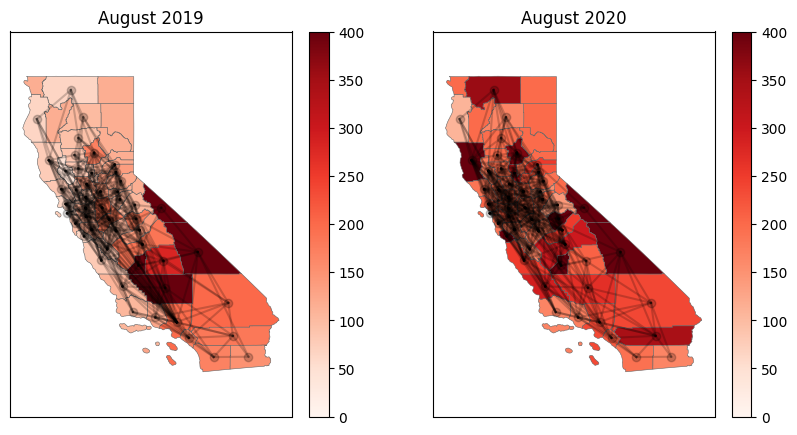

In [78]:


fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_aspect('equal', 'datalim')
axs[1].set_aspect('equal', 'datalim')
shape_in_2019.plot(ax = axs[0], column="value", cmap="Reds", linewidth=0.4, edgecolor=".4", legend=True, vmin = 0, vmax = 400)
shape_in_2020.plot(ax = axs[1], column="value", cmap="Reds", linewidth=0.4, edgecolor=".4", legend=True, vmin = 0, vmax = 400)



pos_1 = 22
pos_2 = 26
print(ts_df.index[::90][pos_1])
print(ts_df.index[::90][pos_2])

for i in range(len(coord_list_spatial[pos_1])):
    axs[0].plot((coord_list_spatial[pos_1][i][0][0], coord_list_spatial[pos_1][i][1][0]), (coord_list_spatial[pos_1][i][0][1], coord_list_spatial[pos_1][i][1][1]), color = "black", alpha = 0.2)
for i in range(len(node_pos_list[pos_1])):
    axs[0].scatter(node_pos_list[pos_1][i][0], node_pos_list[pos_1][i][1], color = "black", alpha = 0.2)

for i in range(len(coord_list_spatial[pos_2])):
    axs[1].plot((coord_list_spatial[pos_2][i][0][0], coord_list_spatial[pos_2][i][1][0]), (coord_list_spatial[pos_2][i][0][1], coord_list_spatial[pos_2][i][1][1]), color = "black", alpha = 0.2)
for i in range(len(node_pos_list[pos_2])):
    axs[1].scatter(node_pos_list[pos_2][i][0], node_pos_list[pos_2][i][1], color = "black", alpha = 0.2)


axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[0].set_title('August 2019')
axs[1].set_title('August 2020')

Plot number of changes and total size

In [34]:
import datetime
avg_temp = [62.3,61.2,63.7,64.9,70.5,69.0,75.2,75.3,76.5,72.9,66.0,59.1,
            62.0,64.1,68.2,65.8,64.2,70.6,73.7,77.1,78.7,75.6,62.6,57.1,
            57.7,64.9,63.2,66.6,65.0,71.3,75.1,73.6,73.7,70.0,65.7,58.6,
            57.1,59.8,65.5,67.8,67.1,71.4,76.4,76.6,75.2,74.1,66.4,61.0,
            62.2,59.4,60.1,64.4,64.9,70.1,78.8,78.3,73.4,70.5,65.1,58.9,
            57.9,54.0,61.1,65.2,63.3,69.3,74.4,75.5,76.6,72.2,64.9,59.4,
            60.9,62.6,61.3,66.6,70.5,71.3,72.2,76.7,76.2,73.0,62.8,60.0,
            59.0,60.5,59.5,64.6,66.3,71.1,74.9,74.4,71.3,66.6,64.0,54.5, 	
            58.5,58.8,61.4,64.3,64.8,71.0,72.4,75.2,77.5,68.7,60.2,57.5	
            ]


high_temp = [   85,82,90,92,102,81,92,91,103,98,90,83,
                85,88,93,92,84,91,92,97,101,100,87,83,
                77,90,87,89,78,101,97,91,104,95,93,82,
                80,80,88,90,94,94,98,102,102,104,93,83,
                86,84,78,95,90,88,108,98,92,90,88,77,
                78,69,69,87,77,92,95,85,97,97,92,77,
                83,88,82,93,95,98,92,98,111,101,91,84,
                88,82,88,90,85,90,90,92,94,93,90,73,
                78,86,85,95,89,90,93,92,103,93,79,84]

temp_dates =  []
for year in range(2014,2022+1):
    for m in range(1,13):
        temp_dates.append(datetime.datetime(year,m,15))

temp_dates = np.array(temp_dates)
avg_temp = np.array(avg_temp)
high_temp = np.array(high_temp)

In [184]:
def get_nr_changes(x,y,tol = 1e-2):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A)>1e-1)

def get_change_size(x,y):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A))

def get_positive_change_size(x,y):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A[A>0]))

def get_negative_change_size(x,y):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(A[A<0])

    
nr_changes = []
change_sizes = []
positive_change_sizes = []
negative_change_sizes = []
thetas = dict_used['thetas'][7][31].copy()
thetas[np.abs(thetas)<1e-2] = 0
for i in range(len(dict_used['thetas'][0][0])-1):
    A1 = thetas[i].copy()
    A2 = thetas[i+1].copy()

    nr_changes.append(get_nr_changes(A2,A1))
    change_sizes.append(get_change_size(A2,A1))
    positive_change_sizes.append(get_positive_change_size(A2,A1))
    negative_change_sizes.append(get_negative_change_size(A2,A1))

variance = []
nr_edges = []

for i in range(len(dict_used['thetas'][0][0])):
    A1 = thetas[i].copy()
    d = A1.shape[0]
    variance.append(np.dot(np.ones(d), np.linalg.inv(A1)).dot(np.ones(d)))
    nr_edges.append(np.sum(A1[np.triu_indices(d, 1)] != 0))


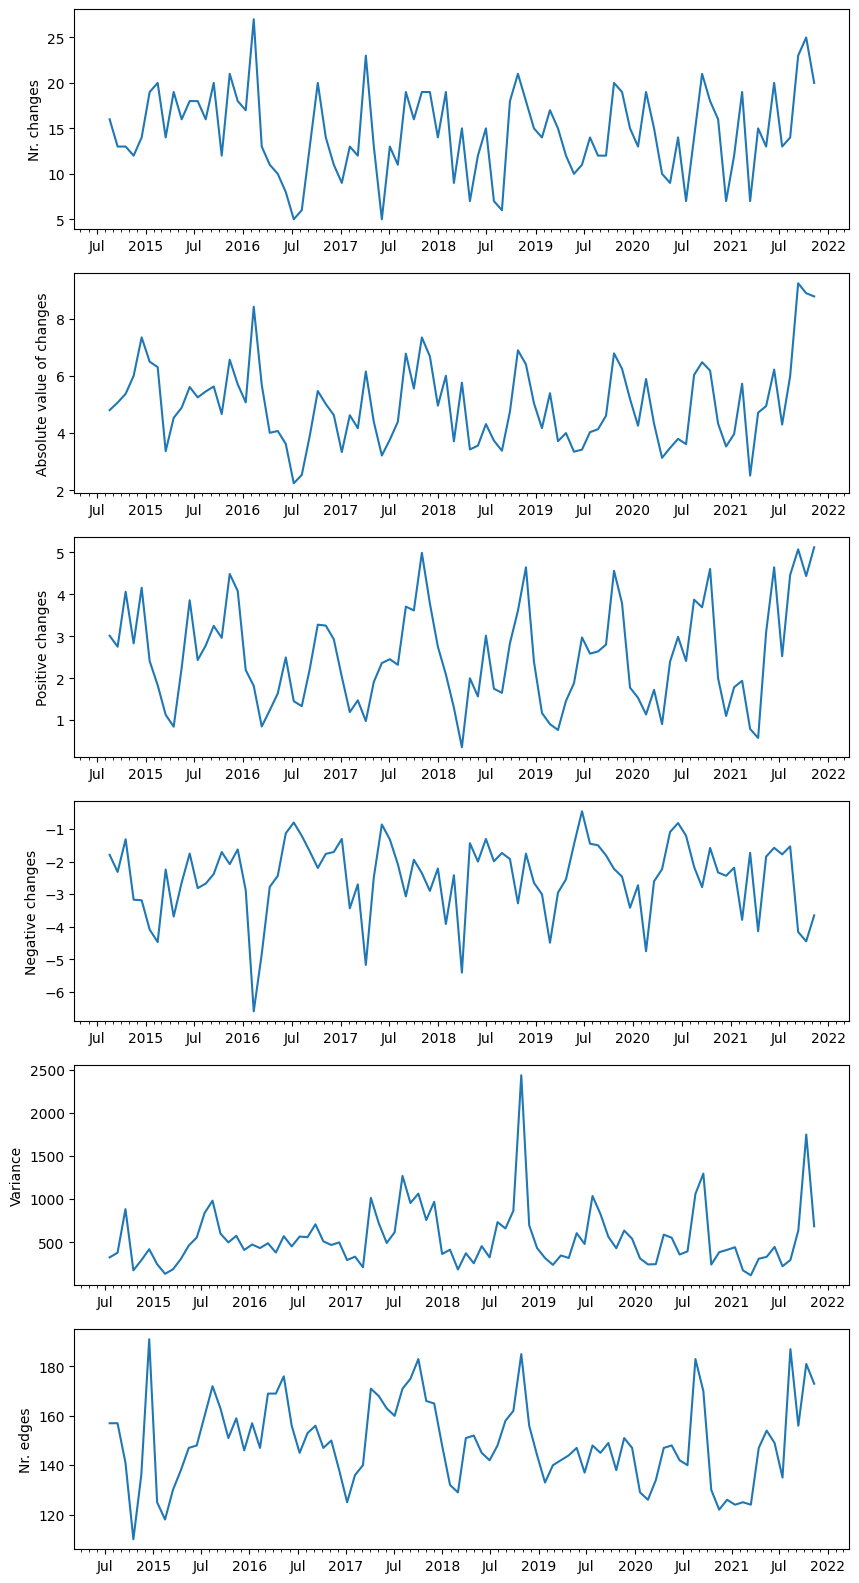

In [185]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

fig, axs = plt.subplots(6,1, figsize = (10,20))
axs[0].plot(pd.to_datetime(AQI_dict_t_spatial['index'][30::30]), nr_changes)
axs[0].set_ylabel("Nr. changes")

axs[1].plot(pd.to_datetime(dict_used['index'][30::30]), change_sizes)
axs[1].set_ylabel("Absolute value of changes")

axs[2].plot(pd.to_datetime(dict_used['index'][30::30]), positive_change_sizes)
axs[2].set_ylabel("Positive changes")

axs[3].plot(pd.to_datetime(dict_used['index'][30::30]), negative_change_sizes)
axs[3].set_ylabel("Negative changes")

axs[4].plot(pd.to_datetime(dict_used['index'][::30]), variance)
axs[4].set_ylabel("Variance")

axs[5].plot(pd.to_datetime(dict_used['index'][::30]), nr_edges)
axs[5].set_ylabel("Nr. edges")

for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # ax.grid(True)
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))



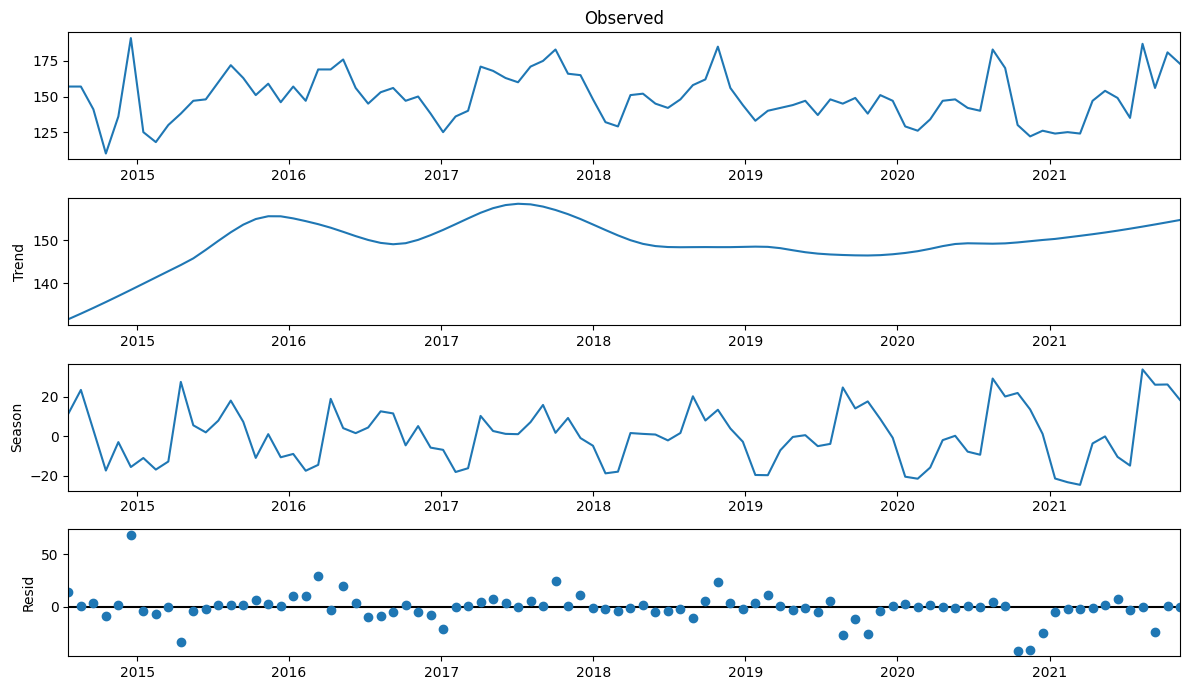

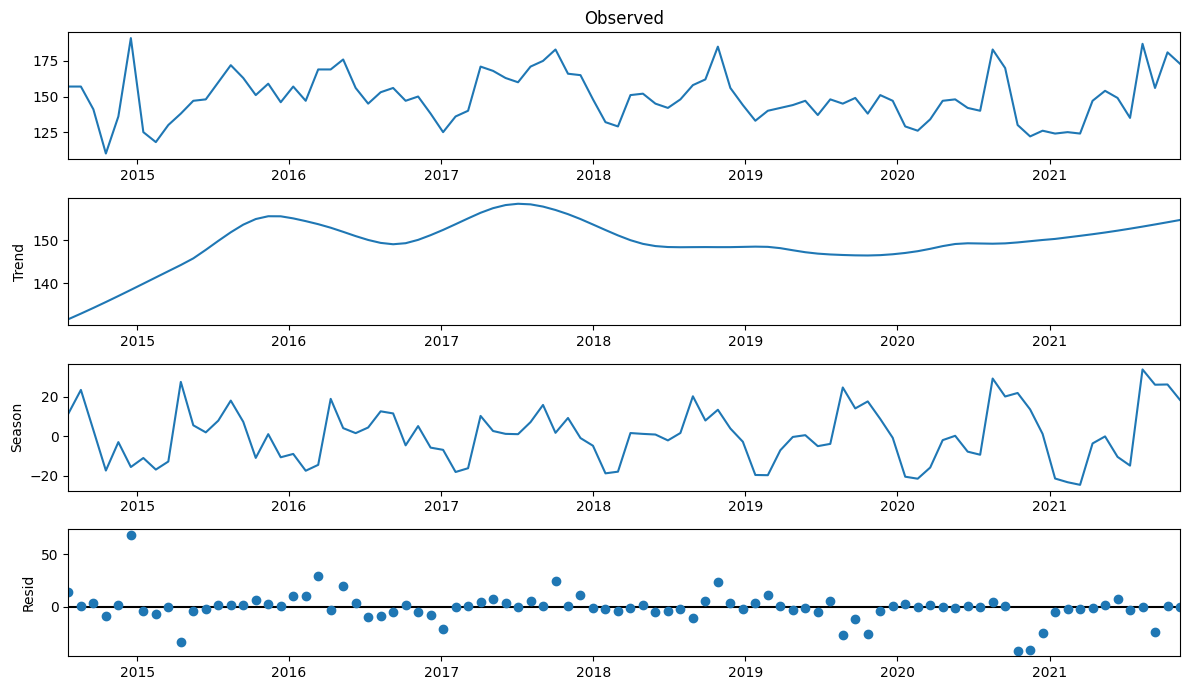

In [186]:
from statsmodels.tsa.seasonal import STL
plt.rc('figure',figsize=(12,7))
stl = STL(pd.DataFrame(nr_edges, index = pd.to_datetime(dict_used['index'][::30])), seasonal=21, period = 12, robust = True)
res = stl.fit()

res.plot()


In [77]:
HDD = pd.read_csv("../data/AQI/HDD.csv")
HDD.head()

,year,Observed,CanESM2 (Average),CNRM-CM5 (Cool/Wet),HadGEM2-ES (Warm/Dry),MIROC5 (Complement)
0,1950,1265.018799,NaN,NaN,NaN,NaN
1,1951,1112.774780,NaN,NaN,NaN,NaN
2,1952,1236.863892,NaN,NaN,NaN,NaN
3,1953,1038.377808,NaN,NaN,NaN,NaN
4,1954,976.274902,NaN,NaN,NaN,NaN


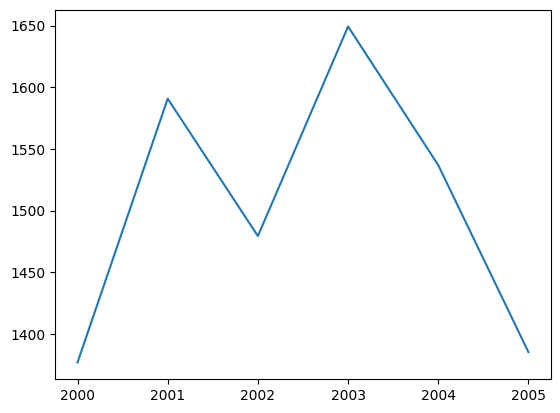

In [79]:
plt.plot(HDD['year'].iloc[50:], HDD['Observed'].iloc[50:])

# Look at simulation

In [5]:
with open(f'./AQIsim/g_spatial_s0.4_tp0.6_2000_200.pkl', 'rb') as handle:
    sim_g = pickle.load(handle)
sim_g.keys()

dict_keys(['obs_per_graph', 'lik_type', 'tol', 'X', 'tail_prob', 'N', 'nr_its', 'alpha', 'kappa', 'alpha_in_CE', 'metric', 'used', 'p', 'sigmas', 'thetas_sim', 'value_vals', 's', 'sparsity', 'schedule_s', 'schedule_tp'])

In [8]:
name_list = []
len(ts_df.columns)
for i in range(0,len(ts_df.columns)):
    for j in range(i+1, len(ts_df.columns)):
        name_list.append(ts_df.columns[i]+ '-' + ts_df.columns[j])


name_list = np.array(name_list)

In [143]:
print(np.where(name_list == 'San Bernardino-Tehama'))
print(np.where(name_list == 'Riverside-San Bernardino'))
print(np.where(name_list == 'Mendocino-Monterey'))

(array([1049], dtype=int64),)
(array([974], dtype=int64),)
(array([762], dtype=int64),)


Text(0, 0.5, 'Probability of none edge')

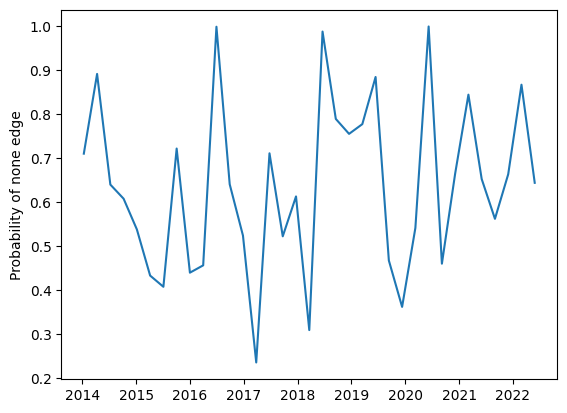

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(ts_df.index[::90],sim_g['p'][:,-1,762])
ax.set_ylabel("Probability of none edge")

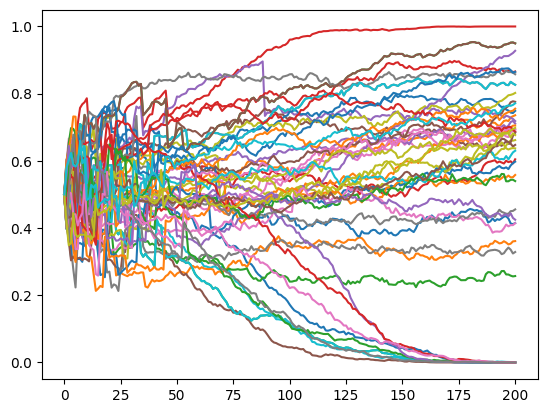

In [10]:
plt.plot(sim_g['p'][0,:,np.random.choice(1225, 50)].T)

In [21]:
50*49/2

1225.0

In [22]:
np.sum(sim_g['p'][1,-1,:] >0.95)

60

In [49]:
np.sum(sim_g['p'][1,-1,:] >0.7)

410

In [31]:
print(AQI_dict_g_spatial['kappas'])
print(AQI_dict_g_spatial['alphas'][24])

[0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1]
0.32527739973026315


In [48]:
thetas_tmp = AQI_dict_g_spatial['thetas'][3][24].copy()
print(thetas_tmp.shape)
np.sum(np.abs(thetas_tmp[0][np.triu_indices(50,1)]) < 1e-3)

(35, 50, 50)


935

In [24]:
sim_g.keys()

dict_keys(['obs_per_graph', 'lik_type', 'tol', 'X', 'tail_prob', 'N', 'nr_its', 'alpha', 'kappa', 'alpha_in_CE', 'metric', 'used', 'p', 'sigmas', 'thetas_sim', 'value_vals', 's', 'sparsity', 'schedule_s', 'schedule_tp'])

# Test global change

In [68]:
def my_hdtest(Z, cov_Z, Y, cov_Y):

    d = Z.shape[1]
    n1 = Z.shape[0]
    n2 = Y.shape[0]

    za = (Z - np.mean(Z,0))
    vz = np.dot((za**2).T, za**2)/n1 - (2/n1 )*np.dot(za.T, za)*cov_Z + cov_Z**2 + 1e-31

    ya = (Y - np.mean(Y,0))
    vy = np.dot((ya**2).T, ya**2)/n2 - (2/n2 )*np.dot(ya.T, ya)*cov_Y + cov_Y**2 + 1e-31

    CLX = np.max((cov_Z-cov_Y)**2/(vz/n1+vy/n2))

    CLX_test = CLX-(4*np.log(d)-np.log(np.log(d)))
    p_val = 1 - np.exp(-np.exp(-CLX_test/2)/(np.sqrt(8*np.pi)))

    return p_val, CLX_test, za, vz, CLX


def plot_global_change(X, thetas, lik_type, cp_shift = 1, nu = 5):

    p_vals = np.zeros(thetas.shape[0]-cp_shift)

    if lik_type == 't':
        const = nu/(nu-1)
    else:
        const = 1


    for t in range(thetas.shape[0]-cp_shift):
        p_vals[t],_, za, vz, CLX = my_hdtest(X[t*90:(t+1)*90], const*np.linalg.inv(thetas[t]), 
                                                    X[(t+cp_shift)*90:(t+cp_shift+1)*90], const*np.linalg.inv(thetas[t+cp_shift]))


    return p_vals


In [64]:
AQI_dict_g.keys()

dict_keys(['thetas', 'nus', 'F_errors', 'alphas', 'kappas', 'obs_per_graph', 'lik_type', 'tol', 'index', 'R', 'X'])

In [88]:
p_vals = plot_global_change(AQI_dict_t['X'], AQI_dict_t['thetas'][5][2].copy(), 't', cp_shift = 4)

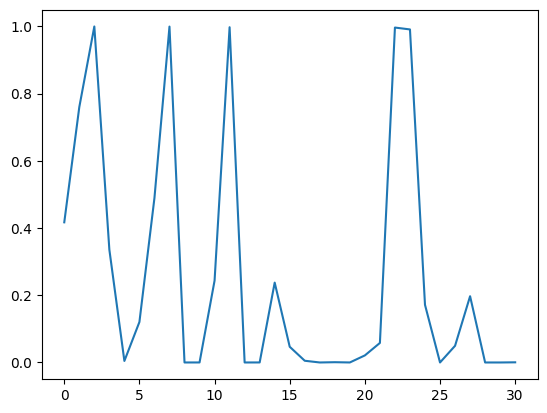

In [89]:
plt.plot(p_vals)

# Test node change

In [99]:
def my_hdtest_node(Z, cov_Z, Y, cov_Y):

    d = Z.shape[1]
    n1 = Z.shape[0]
    n2 = Y.shape[0]

    za = (Z - np.mean(Z,0))
    vz = np.dot((za**2).T, za**2)/n1 - (2/n1 )*np.dot(za.T, za)*cov_Z + cov_Z**2 + 1e-30

    ya = (Y - np.mean(Y,0))
    vy = np.dot((ya**2).T, ya**2)/n2 - (2/n2 )*np.dot(ya.T, ya)*cov_Y + cov_Y**2+ 1e-30

    M_ij = (cov_Z-cov_Y)**2/(vz/n1+vy/n2)

    M_iis = np.diag(M_ij)
    np.fill_diagonal(M_ij,0)
    M_idots = np.max(M_ij, axis = 1)
    

    CLX_tests = M_idots-(2*np.log(d)-np.log(np.log(d)))
    p_vals = 1 - np.exp(-np.exp(-CLX_tests/2)/(np.sqrt(np.pi)))


    return p_vals*(M_iis<2*np.log(d)), CLX_tests



def plot_node_changes(X, thetas, cp_shift = 1,  const = None):

    T = thetas.shape[0]-cp_shift

    if const is None:
        const = np.ones(T)


    node_pvals = np.zeros((T, thetas.shape[1]))


    for t in range(T):
        node_pvals[t],_= my_hdtest_node(X[t*90:(t+1)*90], const[t]*np.linalg.inv(thetas[t]), 
                                                X[(t+cp_shift)*90:(t+cp_shift+1)*90], const[t]*np.linalg.inv(thetas[t+cp_shift]))
    
    return node_pvals





In [106]:
node_pvals = plot_node_changes(AQI_dict_t['X'], AQI_dict_g['thetas'][2][2].copy(), cp_shift = 4)

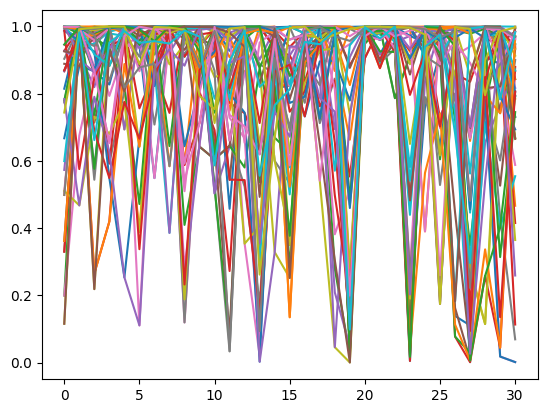

In [107]:
plt.plot(node_pvals)

# Local Edge Change

In [109]:

def Group_fused_lasso(X, Y, d_vec, alpha, max_iter = 100):



    T = X.shape[0]
    p = Y.shape[1]

    beta = np.zeros((T-1, p))


    for j in range(max_iter):
        beta_pre = beta.copy()

        for i in range(T-1):
            beta[i] = 0
            Si = np.dot(X[:,i].T, (Y-np.dot(X, beta)))
            gammai = (i+1)*(T-i-1)*d_vec[i]**2/T
            if np.linalg.norm(Si) == 0:
                beta[i] = 0
            else: 
                beta[i] = np.max((1-alpha/np.linalg.norm(Si),0))*Si/gammai


        if j == 0:
            tol = np.inf
        else:
            tol = np.linalg.norm(beta-beta_pre)

        


    return beta,tol


def find_local_edge_changes(thetas, alpha, max_iter = 100):


    Y = []
    T = thetas.shape[0]
    d = thetas.shape[1]
    p = int(d*(d-1)/2)
    for i in range(T):
        Y.append(thetas[i][np.triu_indices(d,1)])

    Y = np.array(Y)
    print(Y.shape)

    d_vec = np.zeros(T-1)
    for i in range(1,T):
        d_vec[i-1] = np.sqrt(T/(i*(T-i)))

    X = np.zeros((T, T-1))
    for i in range(T):
        for j in range(i):
            X[i,j] = d_vec[j]


    X = X-np.mean(X, axis = 0)
    Y = Y-np.mean(Y, axis = 0)


    beta, reltol = Group_fused_lasso(X,Y,d_vec, alpha, max_iter)




    return beta




In [114]:
beta = find_local_edge_changes(AQI_dict_g['thetas'][2][2].copy(), 1)

(35, 1225)


 ...]

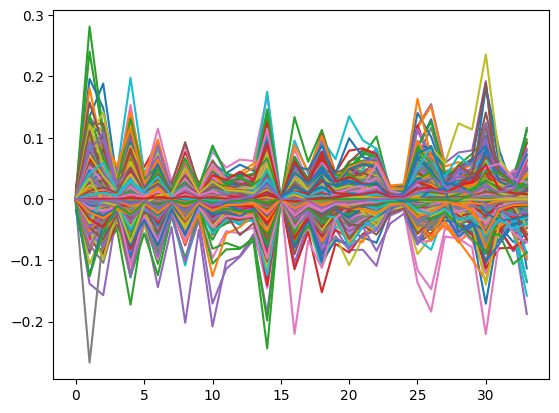

In [115]:
plt.plot(beta)

# TET

In [41]:


spatial = True
obs_per_graph = 90


# Get lat long
wikiurl="https://en.wikipedia.org/wiki/User:Michael_J/County_table"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
sites = pd.read_html(response.content)[-1]
sites = sites.loc[(sites['State'] == 'CA') & np.isin(sites['County [2]'], ts_df.columns)]
sites.head()


sites['Latitude'] = sites['Latitude'].str.replace('°','')
sites['Latitude'] = sites['Latitude'].str.replace('+','')
sites['Latitude'] = sites['Latitude'].str.replace('–','')
sites['Latitude'] = sites['Latitude'].astype(float)
sites['Longitude'] = sites['Longitude'].str.replace('°','')
sites['Longitude'] = sites['Longitude'].str.replace('+','')
sites['Longitude'] = sites['Longitude'].str.replace('–','')
sites['Longitude'] = sites['Longitude'].astype(float)

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d


locs = np.array(sites[['Latitude', 'Longitude']])
d = locs.shape[0]
R = np.zeros((d, d))

for i in range(d):
    for j in range(d):
        R[i,j] = distance(locs[i], locs[j])


if spatial:
    alphas = np.exp(-np.linspace(5, -1.3,40))
    R = R/np.max(R)
else:
    R = 1.0
    alphas = np.exp(-np.linspace(5, 0.5,20))


scaler = StandardScaler()
ts_df_scaled = scaler.fit_transform(ts_df)
assert ts_df_scaled.shape[0] % obs_per_graph == 0, "not divisible by obs_per_graph"

C:\Users\ragna\AppData\Local\Temp\ipykernel_19892\3390301701.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Latitude'] = sites['Latitude'].str.replace('+','')
C:\Users\ragna\AppData\Local\Temp\ipykernel_19892\3390301701.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Longitude'] = sites['Longitude'].str.replace('+','')


In [45]:
dg_opt1 = dg.dygl_inner_em(ts_df_scaled, obs_per_graph=90, max_iter=2000, lamda=0.32*R, kappa = 0.15, tol = 1e-2)
dg_opt1.fit(nr_workers=1, temporal_penalty='element-wise', lik_type = 'gaussian', verbose=False)
#theta_reference = dg_opt1.theta.copy()
#theta_reference[np.abs(theta_reference)<1e-3] = 0

In [47]:
np.sum(np.abs(dg_opt1.theta[0][np.triu_indices(50,1)])<1e-3)

933